<a href="https://colab.research.google.com/github/BenjaminDKLuong/Colab_Notes/blob/master/Smile_Dectection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smile Detection

In [1]:
!git clone https://github.com/PacktPublishing/Real-World-Python-Deep-Learning-Projects.git

Cloning into 'Real-World-Python-Deep-Learning-Projects'...
remote: Enumerating objects: 13503, done.
remote: Total 13503 (delta 0), reused 0 (delta 0), pack-reused 13503
Receiving objects: 100% (13503/13503), 178.97 MiB | 23.81 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Checking out files: 100% (13472/13472), done.


In [0]:
# change working directory to new location
import os
os.chdir("/content/Real-World-Python-Deep-Learning-Projects/Section 4 Code/source")


In [3]:
# check current working directory
%pwd

'/content/Real-World-Python-Deep-Learning-Projects/Section 4 Code/source'

## Data Process

In [4]:
#!/usr/bin/env python3
"""
Prepare images to work with CNN model.

Inspired by https://github.com/kylemcdonald/SmileCNN
We're using data from https://github.com/hromi/SMILEsmileD/tree/master/SMILEs

Download the repository as zip file and put SMILEs/negatives and SMILEs/positives
into the data directory in the source direcotry for this section.

Please install sckit-image package before
using this script with:
$ conda install scikit-image
"""
from os import listdir, path, remove

from skimage.io import imread
from skimage.measure import block_reduce
from PIL import Image

import numpy as np
from keras.utils import np_utils

def img2array(f, detection=False, ii_size=(64, 64)):
    """
    Convert images into matrixes/two-dimensional arrays.

    detection - if True we will resize an image to fit the
                shape of a data that our first convolutional
                layer is accepting which is 32x32 array,
                used only on detection.

    ii_size - this is the size that our input images have.
    """
    rf=None
    if detection:
        rf=f.rsplit('.')
        rf=rf[0]+'-resampled.'+rf[1]
        im = Image.open(f)
        # Create a smaller scalled down thumbnail
        # of our image.
        im.thumbnail(ii_size)
        # Our thumbnail might not be of a perfect
        # dimensions, so we need to create a new
        # image and paste the thumbnail in.
        newi = Image.new('L', ii_size)
        newi.paste(im, (0,0))
        newi.save(rf, "JPEG")
        f=rf
    # Turn images into an array.
    data=imread(f, as_gray=True)
    # Downsample it from 64x64 to 32x32
    # (that's what we need to feed into our first convolutional layer).
    data=block_reduce(data, block_size=(2, 2), func=np.mean)
    if rf:
        remove(rf)
    return data

def prep_array(data, detection=False):
    """
    Convert our input array into the right format.

    detection - if True we just wrapping up a single
                image's array into a list to make things
                consistent.
    """
    if detection:
        data=[data]
    # By default values converted from our images
    # are integers in range from 0 to 255 and our
    # network will be really slow working with them.
    # So, we need to convert them into values from
    # 0.0 to 1.0 range which works much better in our case.
    data=np.asarray(data) / 255.0
    # We need to wrap each pixel value insided it's own array.
    # This is the quick way of doing it.
    data=np.expand_dims(data, axis=-1)
    return data
  
    '''
    prep_array turn 

    From This: 
    [[1 2 3]
     [3 2 1]]

    TO THIS:
    [[[1]
      [2]
      [3]]

     [[3]
      [2]
      [1]]]
    '''
  
  
  
def load_data(data_directory):
    """
    Go trough each image in a data directory,
    convert it into an array, add into
    our input array X and return it.
    """
    X=[]
    for filename in listdir(data_directory):
        if not filename.endswith('.jpg'):
            continue
        p=path.join(data_directory, filename)
        data=img2array(p)
        X.append(data)
    return prep_array(X)

def gen_labels(length, label):
    """
    Return a length list of label.
    """
    return [ label for _ in range(length) ]

def get_data():
    """
    Generate X and Y arrays, inputs and classes
    ready for use in our convolutional network.
    """
    # Load images, generate labels, starting with negatives
    x_neg = load_data('data/negatives/negatives7')
    y_neg = gen_labels(len(x_neg), 0)

    x_pos = load_data('data/positives/positives7')
    y_pos = gen_labels(len(x_pos), 1)

    # Merge negative and postive data into one.
    X=np.concatenate([x_neg, x_pos])
    Y=np.asarray(y_neg+y_pos)

    # By default we will have 64 bit values,
    # it will run quicker if we convert them into
    # 32 bit.
    X = X.astype(np.float32)
    Y = Y.astype(np.int32)

    # Get the dimensions and number of color channels
    # that we have in our data.
    # Here we have (32,32,1) which means 32x32 array with
    # one color channel (because we have black and white images)
    inputs=X.shape[1:]
    # Number of classes we want to predict.
    # 0 - not smiling, 1 - smiling.
    classes=2
    # Convert classes to vector, this is needed when we use
    # softmax in the last layer.
    Y = np_utils.to_categorical(Y, classes).astype(np.float32)

    # Shuffle all the data because
    # we have more negative samples
    # than positive ones.
    # Then keras will take care of
    # spliting the data for us
    # later on training.
    ixes = np.arange(len(X))
    np.random.shuffle(ixes)
    X = X[ixes]
    Y = Y[ixes]
    return X, Y, inputs, classes


Using TensorFlow backend.


In [6]:
from pprint import pprint

X, Y, inputs, classes=get_data()

print('Inputs: %s' % repr(inputs))

print('X[0] (first encoded image):')
pprint(X[0])

print('Y[0] (first encoded class):')
pprint(Y[0])

print('Classes %s' % classes)

pprint(np_utils.to_categorical([0,1], classes).astype(np.float32))


Inputs: (32, 32, 1)
X[0] (first encoded image):
array([[[0.20196079],
        [0.17843138],
        [0.2647059 ],
        ...,
        [0.6117647 ],
        [0.65      ],
        [0.18921569]],

       [[0.23627451],
        [0.31764707],
        [0.40882352],
        ...,
        [0.5882353 ],
        [0.5921569 ],
        [0.15882353]],

       [[0.42352942],
        [0.46960783],
        [0.45784312],
        ...,
        [0.59411764],
        [0.5862745 ],
        [0.15686275]],

       ...,

       [[0.7921569 ],
        [0.6970588 ],
        [0.3647059 ],
        ...,
        [0.12843138],
        [0.17352942],
        [0.1882353 ]],

       [[0.6764706 ],
        [0.89117646],
        [0.5176471 ],
        ...,
        [0.11960784],
        [0.17352942],
        [0.21568628]],

       [[0.52156866],
        [0.9245098 ],
        [0.65686274],
        ...,
        [0.1254902 ],
        [0.17941177],
        [0.19901961]]], dtype=float32)
Y[0] (first encoded class):
array([1., 0.]

## Train

In [0]:
#!/usr/bin/env python3
"""
Build, train and evaluate a CNN model for smile recognition.
"""
import conf
from prep import get_data

from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D

import os
import sys


def get_smile_cnn(inputs=(32,32,1), classes=2):
    """
    Define our CNN model for simple recognition.

    inputs - a tupe of (rows, cols, channel) of our input arrays,
             describing the "shape" of our data, we need to provide
             it for the first Convolutional layer.

    classes - a number of classes we want to predict, here we have
              only two classes - 0 - not smiling, 1 - smiling.
    """
    model = Sequential()
    # X filters will create an X feature maps, the more we have
    # the more "features" we can "catch".
    # Kernel size is the size of a matrix that will extract
    # our "features".
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=inputs))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    # Factors by which to downscale and choose the maximum/most visible
    # values.
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # % of neurons to ignore/help with making your model
    # being more general, doing better on unseen data.
    # 0.25 means 25%, try to comment out Dropout layers
    # and see what happens...
    model.add(Dropout(0.25))
    model.add(Flatten())
    # Adding a fully connected layer just before last layer
    # help us learn the combinations of features from previous
    # feature maps (results of Conv2D and MaxPooling2D layers).
    model.add(Dense(128, activation='relu'))
    # Same as comment above.
    model.add(Dropout(0.5))
    # Last layer is for classification, softmax allows us
    # to recognize a few different classes.
    model.add(Dense(classes, activation='softmax'))
    return model

confs={'default': dict(model=get_smile_cnn)}

def train_model(name, train_x, train_y, epochs, batches, inputs, classes):
    """
    Compile and train model with choosen parameters.
    """
    mparams=confs[name]
    model=mparams['model']
    model=model(inputs, classes)
    
    # Compile model.
    # We're using categorical_* and softmax function in the last
    # layer to classify multiple classes.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # We're using 90% of data for training and 10% for validation/testing.
    trs, tt=int(len(train_x)*0.90), int(len(train_x)*0.10)
    train_x, train_y, test_x, test_y=train_x[0:trs], train_y[0:trs], train_x[-tt:], train_y[-tt:]
    
    # Fit model on training data, validate during training on test data.
    model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=epochs, batch_size=batches, verbose=2)
    return model, name, mparams, train_x, train_y, test_x, test_y



In [8]:
# Getting our command line parameters
name = 'default'
epochs = 15
batches= 32


# Time for training!
model, name, mp, train_x, train_y, test_x, test_y =train_model(name, X, Y, epochs, batches, inputs, classes)

# Save model to use for classification later on.
mname='models/model-%s-%d-%d' % (name, epochs, batches)
model.save(mname+'.h5')

title='%s (epochs=%d, batch_size=%d)' % (name, epochs, batches)
print('Evaluation for %s' % title)

loss, acc = model.evaluate(train_x, train_y, verbose=2)
print('Train accuracy: %.2f%%' % (acc*100))

loss, acc = model.evaluate(test_x, test_y, verbose=2)
print('Test accuracy: %.2f%%' % (acc*100))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 11849 samples, validate on 1316 samples
Epoch 1/15
 - 6s - loss: 0.4176 - acc: 0.8085 - val_loss: 0.3029 - val_acc: 0.8822
Epoch 2/15
 - 2s - loss: 0.2974 - acc: 0.8787 - val_loss: 0.2611 - val_acc: 0.8853
Epoch 3/15
 - 2s - loss: 0.2655 - acc: 0.8963 - val_loss: 0.2357 - val_acc: 0.8989
Epoch 4/15
 - 2s - loss: 0.2461 - acc: 0.9044 - val_loss: 0.2246 - val_acc: 0.9020
Epoch 5/15
 - 2s - loss: 0.2294 - acc: 0.9132 - val_loss: 0.2134 - val_acc: 0.9081
Epoch 6/15
 - 2s - loss: 0.2164 - acc: 0.9168 - val_loss: 0.2157 - val_acc: 0.9119
Epoch 7/15
 - 2s - loss: 0.2069 - acc: 0.9223 - val_loss: 0.2109 - val_acc: 0.9149
Epoch 8/15
 - 2s - loss: 0.1977 - acc: 0.9228 - val_loss: 0.2136 - val_acc: 0.9103
Epoch 9/15
 - 2s - loss: 0.1896 - acc: 0.9276 - val_

## Predict


In [0]:
# LOAD MODEL
from keras.models import load_model

name = 'default'
epochs = 15
batches= 32

mname='models/model-%s-%d-%d' % (name, epochs, batches)
model_file = mname+'.h5'

if os.path.exists(model_file):
    model=load_model(model_file)
else:
    print("Can't find %s model, train it first using 'train.py %s %d %d'" % (mname, name, epochs, batches))
    exit(1)



In [0]:
# image path
filename= '/content/Real-World-Python-Deep-Learning-Projects/Section 4 Code/source/data/new_samples/1-ns.jpg'
# convert input images
img_data = prep_array(img2array(filename, detection=True), detection=True)

In [21]:
# predict using the model
pc=model.predict_classes(img_data)
pc=pc[0]
# Here the probablity for each class.
prob=model.predict_proba(img_data)
prob=prob[0]
# If our prediction doesn't match file's mark (0/-ns for no smile, 1/-s for smile)
# mark it with star for examiation.
fname=filename.split('/')[-1]
if pc==0:
    print('I think this person is NOT SMILING (%.2f%% sure)' % (prob[0]*100))
    if '-ns' in fname:
      print("The prediction is CORRECT")
    else:
      print("The prediction is NOT CORRECT")
if pc==1:
    print('I think this person is SMILING (%.2f%% sure)' % (prob[1]*100))
    if '-ns' in fname:
      print("The prediction is CORRECT")
    else:
      print("The prediction is NOT CORRECT")
#print(filename, '\n%s (%.2f%% of smile(1/-s), %.2f%% of no smile(0/-ns))' % (fmark, prob[1]*100, prob[0]*100))


I think this person is NOT SMILING (98.38% sure)
The prediction is CORRECT


## Input Image Visualization

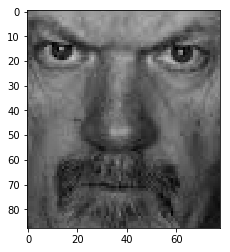

In [20]:
# importing matplotlib modules 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 


# Read Images 
img = mpimg.imread(filename) 
  
# Output Images 
plt.imshow(img) 
